# Import packages

In [36]:
from array import array
import itertools
import time
import math

import matplotlib

import matplotlib.pyplot as plt
import sys
sys.path.insert(0,'/usr/common/software/rootpy/')
import root_numpy
import numpy as np

#import astroML.plotting as aml
#import iminuit
import pandas as pd
import root_pandas as rpd
from root_pandas import read_root
import ROOT
from ROOT import TH1D
from ROOT import SetOwnership
from matplotlib.ticker import NullFormatter
from ROOT import TLatex

# File

In [37]:
#RootFile = '13d_4L_GMB_newphi_ratio.root'
#RootFile = '13f_4L_GMB_ratio.root'
#RootFile = '13d_4L_SE_GMB_Ratio.root'
RootFile = '13e_4L_SE_GMB_Ratio.root'
RootFile = 'InputData/17q_GMB_Correlation.root'

# Define Bins and Purity


In [38]:
#FIXME: Read from Corr_config.yaml
zTbins = [0.05, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2]
#pTbins = [0,0,10, 16]
pTbins = [0,0,12, 15]
purity = [0.207, 0.241, 0.30]

## Plot Titles

In [39]:
def Plot1D (histo, ptbin, ztbin,DNN_Bool):
    #histo.SetTitle("#gamma - h : p_{T}^{Clus.}(%1.1f-%1.1f),  z_{T}(%1.2f-%1.2f)"
    #               %(pTbins[ptbin],pTbins[ptbin+1],zTbins[ztbin],zTbins[ztbin+1]))
    
    histo.SetTitle("#gamma - h : p_{T}^{Clus.}(%1.1f-%1.1f),  z_{T}(%1.2f-%1.2f)"%(12,15,zTbins[ztbin],zTbins[ztbin+1]))
    
    histo.GetXaxis().SetTitle("#Delta#phi")
    histo.GetYaxis().SetTitle("#frac{d^{2}N}{d#phid#eta}")
    #histo.GetYaxis().SetTitle("#frac{d^{2}N}{d#phid#eta}")
    histo.GetYaxis().SetTitleOffset(1.35)
    ROOT.gStyle.SetOptStat("")
    histo.SetMarkerStyle(20)
    histo.SetMarkerSize(2)
    histo.SetLineColor(4)
    histo.SetMarkerColor(4)
    if not(DNN_Bool):
        histo.SetLineColor(2)
        histo.SetMarkerColor(2)

<sup> **Note** Scaling is done cell by cell (despite Axis title here) for accurate subtraction<sup>

# ZYAM

In [40]:
def Subtract_ZYAM (PhiProjection):
    nbins = PhiProjection.GetSize()-2 #underflow,overflow

    #zyam = PhiProjection.Integral(3,4)/2
    Z_min = (PhiProjection.GetXaxis().FindBin(0.9)) #avoid bias of isolation in this region  
    Z_max = (PhiProjection.GetXaxis().FindBin(1.5)-1)
    Z_N = Z_max-Z_min+1
    zyam = PhiProjection.Integral(Z_min,Z_max)/(Z_N)
    

    for i in range(nbins+1):
            y = PhiProjection.GetBinContent(i)
            y_error = PhiProjection.GetBinError(i)
            new_y = y-zyam
            PhiProjection.SetBinContent(i,new_y)
            #assumes 0 error in ZYAM
            new_y_error = y_error
            PhiProjection.SetBinError(i,new_y_error)

In [41]:
def ZYAM_Line(hsig):
    Z_min = (hsig.GetXaxis().FindBin(0.9)) #avoid bias of isolation in this region  
    Z_max = (hsig.GetXaxis().FindBin(1.5)-1)
    Z_N = Z_max-Z_min+1
    zyam_value = hsig.Integral(Z_min,Z_max)/(Z_N)
    print Z_min, Z_max, Z_N
    ZYAM = ROOT.TLine(0,zyam_value,math.pi,zyam_value)
    ZYAM.SetLineColorAlpha(7, 0.9)
    ZYAM.SetLineWidth(5)
    SetOwnership(ZYAM, 0)
    return ZYAM

## N Triggers

In [42]:
def Get_NTriggers(filename, ipt, Signal_DNN=True):
    DNN_Rgn = int(Signal_DNN) + 2*(1-int(Signal_DNN)) 
    file = ROOT.TFile(filename)
    ntrig_histo = file.Get('N_DNN%i_Triggers_pT%1.0f_%1.0f' %(DNN_Rgn,pTbins[ipt],pTbins[ipt+1]))
    NTriggers = 1
    if not(ntrig_histo == None):
        NTriggers = ntrig_histo.GetEntries()
    file.Close()
    return NTriggers

## Large $\eta$

In [43]:
def GetLEProj(filename, ipt, izt, Signal_DNN=True):

    DNN_Rgn = int(Signal_DNN) + 2*(1-int(Signal_DNN)) #convert bool to DNN_1 (Sgn) or DNN_2 (Bkgd)
    file = ROOT.TFile(filename)
    
    histo2D = file.Get('DNN%i_Correlation__pT%1.0f_%1.0f__zT%1.0f_zT%1.0f' 
                       %(DNN_Rgn,pTbins[ipt],pTbins[ipt+1],10*zTbins[izt],10*zTbins[izt+1]))
    #Project
    Eta_Axis = histo2D.GetYaxis()
    
    LE_PhiProjection = histo2D.ProjectionX('NegEta_DNN%i_PhiProjection__pT_%1.0f_%1.0f__zt_%1.0f_%1.0f' 
                                  %(DNN_Rgn,pTbins[ipt],pTbins[ipt+1],10*zTbins[izt],
                                    10*zTbins[izt+1]),Eta_Axis.FindBin(-1.4),Eta_Axis.FindBin(-0.8))
    
    PhiProjection_pos = histo2D.ProjectionX('PosEta_DNN%i_PhiProjection__pT_%1.0f_%1.0f__zt_%1.0f_%1.0f' 
                                  %(DNN_Rgn,pTbins[ipt],pTbins[ipt+1],10*zTbins[izt],
                                    10*zTbins[izt+1]),Eta_Axis.FindBin(0.8),Eta_Axis.FindBin(1.4))

    #Add,scale 
    LE_PhiProjection.SetDirectory(0)
    LE_PhiProjection.Add(PhiProjection_pos,1)
    #LE_PhiProjection.Rebin(2)
    LE_PhiProjection.Scale(1.0/1.2) #scale by eta region
    Plot1D(LE_PhiProjection,ipt,izt,Signal_DNN)
    LE_PhiProjection.SetMarkerStyle(25)
    LE_PhiProjection.SetLineColor(1)
    LE_PhiProjection.SetMarkerSize(2)
    LE_PhiProjection.SetMarkerColor(1)

    ntriggers = Get_NTriggers(filename, ipt, Signal_DNN)    
    if not(ntriggers == None):
        LE_PhiProjection.Scale(1.0/ntriggers) #per trigger yield
        
    #Legend
    #legend = ROOT.TLegend(0.64,0.78,0.89,0.88)
    legend = ROOT.TLegend(0.14,0.76,0.38,0.88)
    LE_PhiProjection.SetLineColorAlpha(1,0.9) #8 for light green
    #legend.AddEntry(LE_PhiProjection, "0.8 <|#eta| < 1.4","p")
    SetOwnership(legend, 0)
    file.Close()
    return LE_PhiProjection,legend

#### Simplify above with calls to getPhiProjection()

In [44]:
def GetLE_Line(LE_Proj):
    LE_min = (LE_Proj.GetXaxis().FindBin(0.4)+1) #avoid bias of isolation in this region  
    LE_max = (LE_Proj.GetXaxis().FindBin(1.4)-1)
    LE_N = LE_max-LE_min+1
    LE_value = LE_Proj.Integral(LE_min,LE_max)/(LE_N)
    
    LE_Line = ROOT.TLine(0,LE_value,math.pi,LE_value)
    LE_Line.SetLineColorAlpha(1, 0.9)
    LE_Line.SetLineWidth(5)
    SetOwnership(LE_Line, 0)
    #legend
    legend = ROOT.TLegend(0.74,0.78,0.89,0.88)
    legend.AddEntry(LE_Line, "0.8 <|#eta| < 1.4","l")
    SetOwnership(legend, 0)
    return LE_Line,legend

In [45]:
def Subtract_LE(PhiProjection,LE_Proj):
    nbins = PhiProjection.GetSize()-2 #underflow,overflow    

    LE_min = (LE_Proj.GetXaxis().FindBin(0.4)+1) #avoid bias of isolation in this region  
    LE_max = (LE_Proj.GetXaxis().FindBin(1.4)-1)
    LE_N = LE_max-LE_min+1
    LE = LE_Proj.Integral(LE_min,LE_max)/(LE_N)
    
    for i in range(nbins+1):
            y = PhiProjection.GetBinContent(i)
            y_error = PhiProjection.GetBinError(i)
            new_y = y-LE
            PhiProjection.SetBinContent(i,new_y)
            new_y_error = y_error
            PhiProjection.SetBinError(i,new_y_error)

#### Check

In [46]:
#LE,legend = GetLEProj(RootFile, 0, 0, True)
#cav = ROOT.TCanvas("cav","cav", 500,160)
#LE.Draw()
#legend.Draw()
#cav.Draw()
#GetLE_Line(LE)

<sup>**NOTE**: The DNN corresponding to one photon is reflected in the naming scheme of histograms, where DNN1_Histo is signal (the same here) but background (DNN corresponding to 2 photons) is DNN2_Histo. Here, the DNN variable is a boolian corresponding to *true for signal*, *false for background* (not signal)<sup>

# Get Phi Projection

In [47]:
def GetPhiProj(filename, ipt, izt, Signal_DNN=True, doZYAM=True):

    DNN_Rgn = int(Signal_DNN) + 2*(1-int(Signal_DNN)) #convert bool to DNN_1 (Sgn) or DNN_2 (Bkgd)
    file = ROOT.TFile(filename)
    histo2D = file.Get('DNN%i_Correlation__pT%1.0f_%1.0f__zT%1.0f_zT%1.0f' 
                        %(DNN_Rgn,pTbins[ipt],pTbins[ipt+1],10*zTbins[izt],10*zTbins[izt+1]))
    
    #integral
    Eta_Axis = histo2D.GetYaxis()
    bin1 = Eta_Axis.FindBin(-0.6)
    PhiProjection = histo2D.ProjectionX('DNN%i_PhiProjection__pT_%1.0f_%1.0f__zt_%1.0f_%1.0f' 
                                  %(DNN_Rgn,pTbins[ipt],pTbins[ipt+1],10*zTbins[izt],
                                    zTbins[izt+1]),Eta_Axis.FindBin(-0.6),Eta_Axis.FindBin(0.6))
                                    #10*zTbins[izt+1]),5,11)
    PhiProjection.SetDirectory(0)
    #PhiProjection.Rebin(2)
    PhiProjection.Scale(1.0/1.2) #scale by eta region
    PhiProjection.SetMarkerStyle(20)
    
    ntriggers = Get_NTriggers(filename, ipt, Signal_DNN)
    if not(ntriggers == None):
        PhiProjection.Scale(1.0/ntriggers) #per trigger yield
        
        
    Plot1D(PhiProjection,ipt,izt,Signal_DNN)    
    if(doZYAM):
        LE_Proj,legend = GetLEProj(filename, ipt, izt, Signal_DNN)
        Subtract_LE(PhiProjection,LE_Proj)
        #Subtract_ZYAM(PhiProjection)
    
    file.Close()
    return PhiProjection

<sup>**NOTE**: SetDirectory(0) needed because when a file in root is called, the gDirectory is changed to point to it. The creation of a histogram (PhiProjection) is associated to that file and contains a local reference, which is destroyed when the function exits. Thus, returns 'None' unless the Directory (reference) is changed. Root is annoying.</sup>

### Side By Side

In [48]:
def SideSide():
    #for ptbin in range(3):
        ptbin = 0
        #if(ptbin > 0): continue
        ptbin = ptbin+2;
        canvases = ROOT.TCanvas("Canv_Side_Side_%i"%(ptbin),"Canv_Side_Side_%i"%(ptbin),3500,2500)
        #canvases = ROOT.TCanvas("Canv_Side_Side_%i"%(ptbin),"Canv_Side_Side_%i"%(ptbin),1000,800)
        canvases.Divide(4,3)
        for ztbin in range(6):

            #grab
            hsig = GetPhiProj(RootFile,ptbin,ztbin,True,False) #no subtraction, change DNN
            hbkg = GetPhiProj(RootFile,ptbin,ztbin,False,False)

            #same scale
            ymax = 1.2*max(hsig.GetMaximum(),hbkg.GetMaximum())
            hsig.GetYaxis().SetRangeUser(0,ymax)
            hbkg.GetYaxis().SetRangeUser(0,ymax)    

            #Signal
            canvases.cd(ztbin*2+1)            
            Sig_ZYAM= ZYAM_Line(hsig) #Change to UnCorr_Line, swith to high rapidity
            LE_sig,legend = GetLEProj(RootFile, ptbin, ztbin,True)
            LE_Line,temp = GetLE_Line(LE_sig)
            
            hsig.Draw()            
            Sig_ZYAM.Draw("same")
            LE_Line.Draw("same")
            hsig.Draw("same")
            LE_sig.Draw("same")
            legend.AddEntry(Sig_ZYAM, "ZYAM","l")
            legend.AddEntry(hsig,"High DNN","p")
            legend.AddEntry(LE_sig, "0.8 <|#eta| < 1.4","p")
            legend.Draw("same")

            #Background
            canvases.cd(ztbin*2+2)
            BKG_ZYAM = ZYAM_Line(hbkg)
            LE_bkg,legend = GetLEProj(RootFile, ptbin, ztbin, False)
            LE_bkg_Line,temp = GetLE_Line(LE_bkg)
            hbkg.Draw()
            BKG_ZYAM.Draw("same")
            LE_bkg_Line.Draw("same")
            hbkg.Draw("same")
            LE_bkg.Draw("same")
            legend.AddEntry(BKG_ZYAM, "ZYAM","l")
            legend.AddEntry(hbkg,"Low DNN","p")
            legend.AddEntry(LE_bkg, "0.8 <|#eta| < 1.4","p")
            #legend.AddEntry(LE_bkg_Line, "0.8 > |#Delta#eta| > 1.4","l")
            legend.Draw("same")
        canvases.Update()
        canvases.Draw()
        canvases.SaveAs("pics/Same_Mix_per_Trigger_pt_%i.png"%(ptbin))
        print ptbin
        return canvases
#myText(.2,.2,"hello_%i"%number,1)

TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: Canv_Side_Side_2


5 7 3
5 7 3
5 7 3
5 7 3
5 7 3
5 7 3
5 7 3
5 7 3
5 7 3
5 7 3
5 7 3
5 7 3


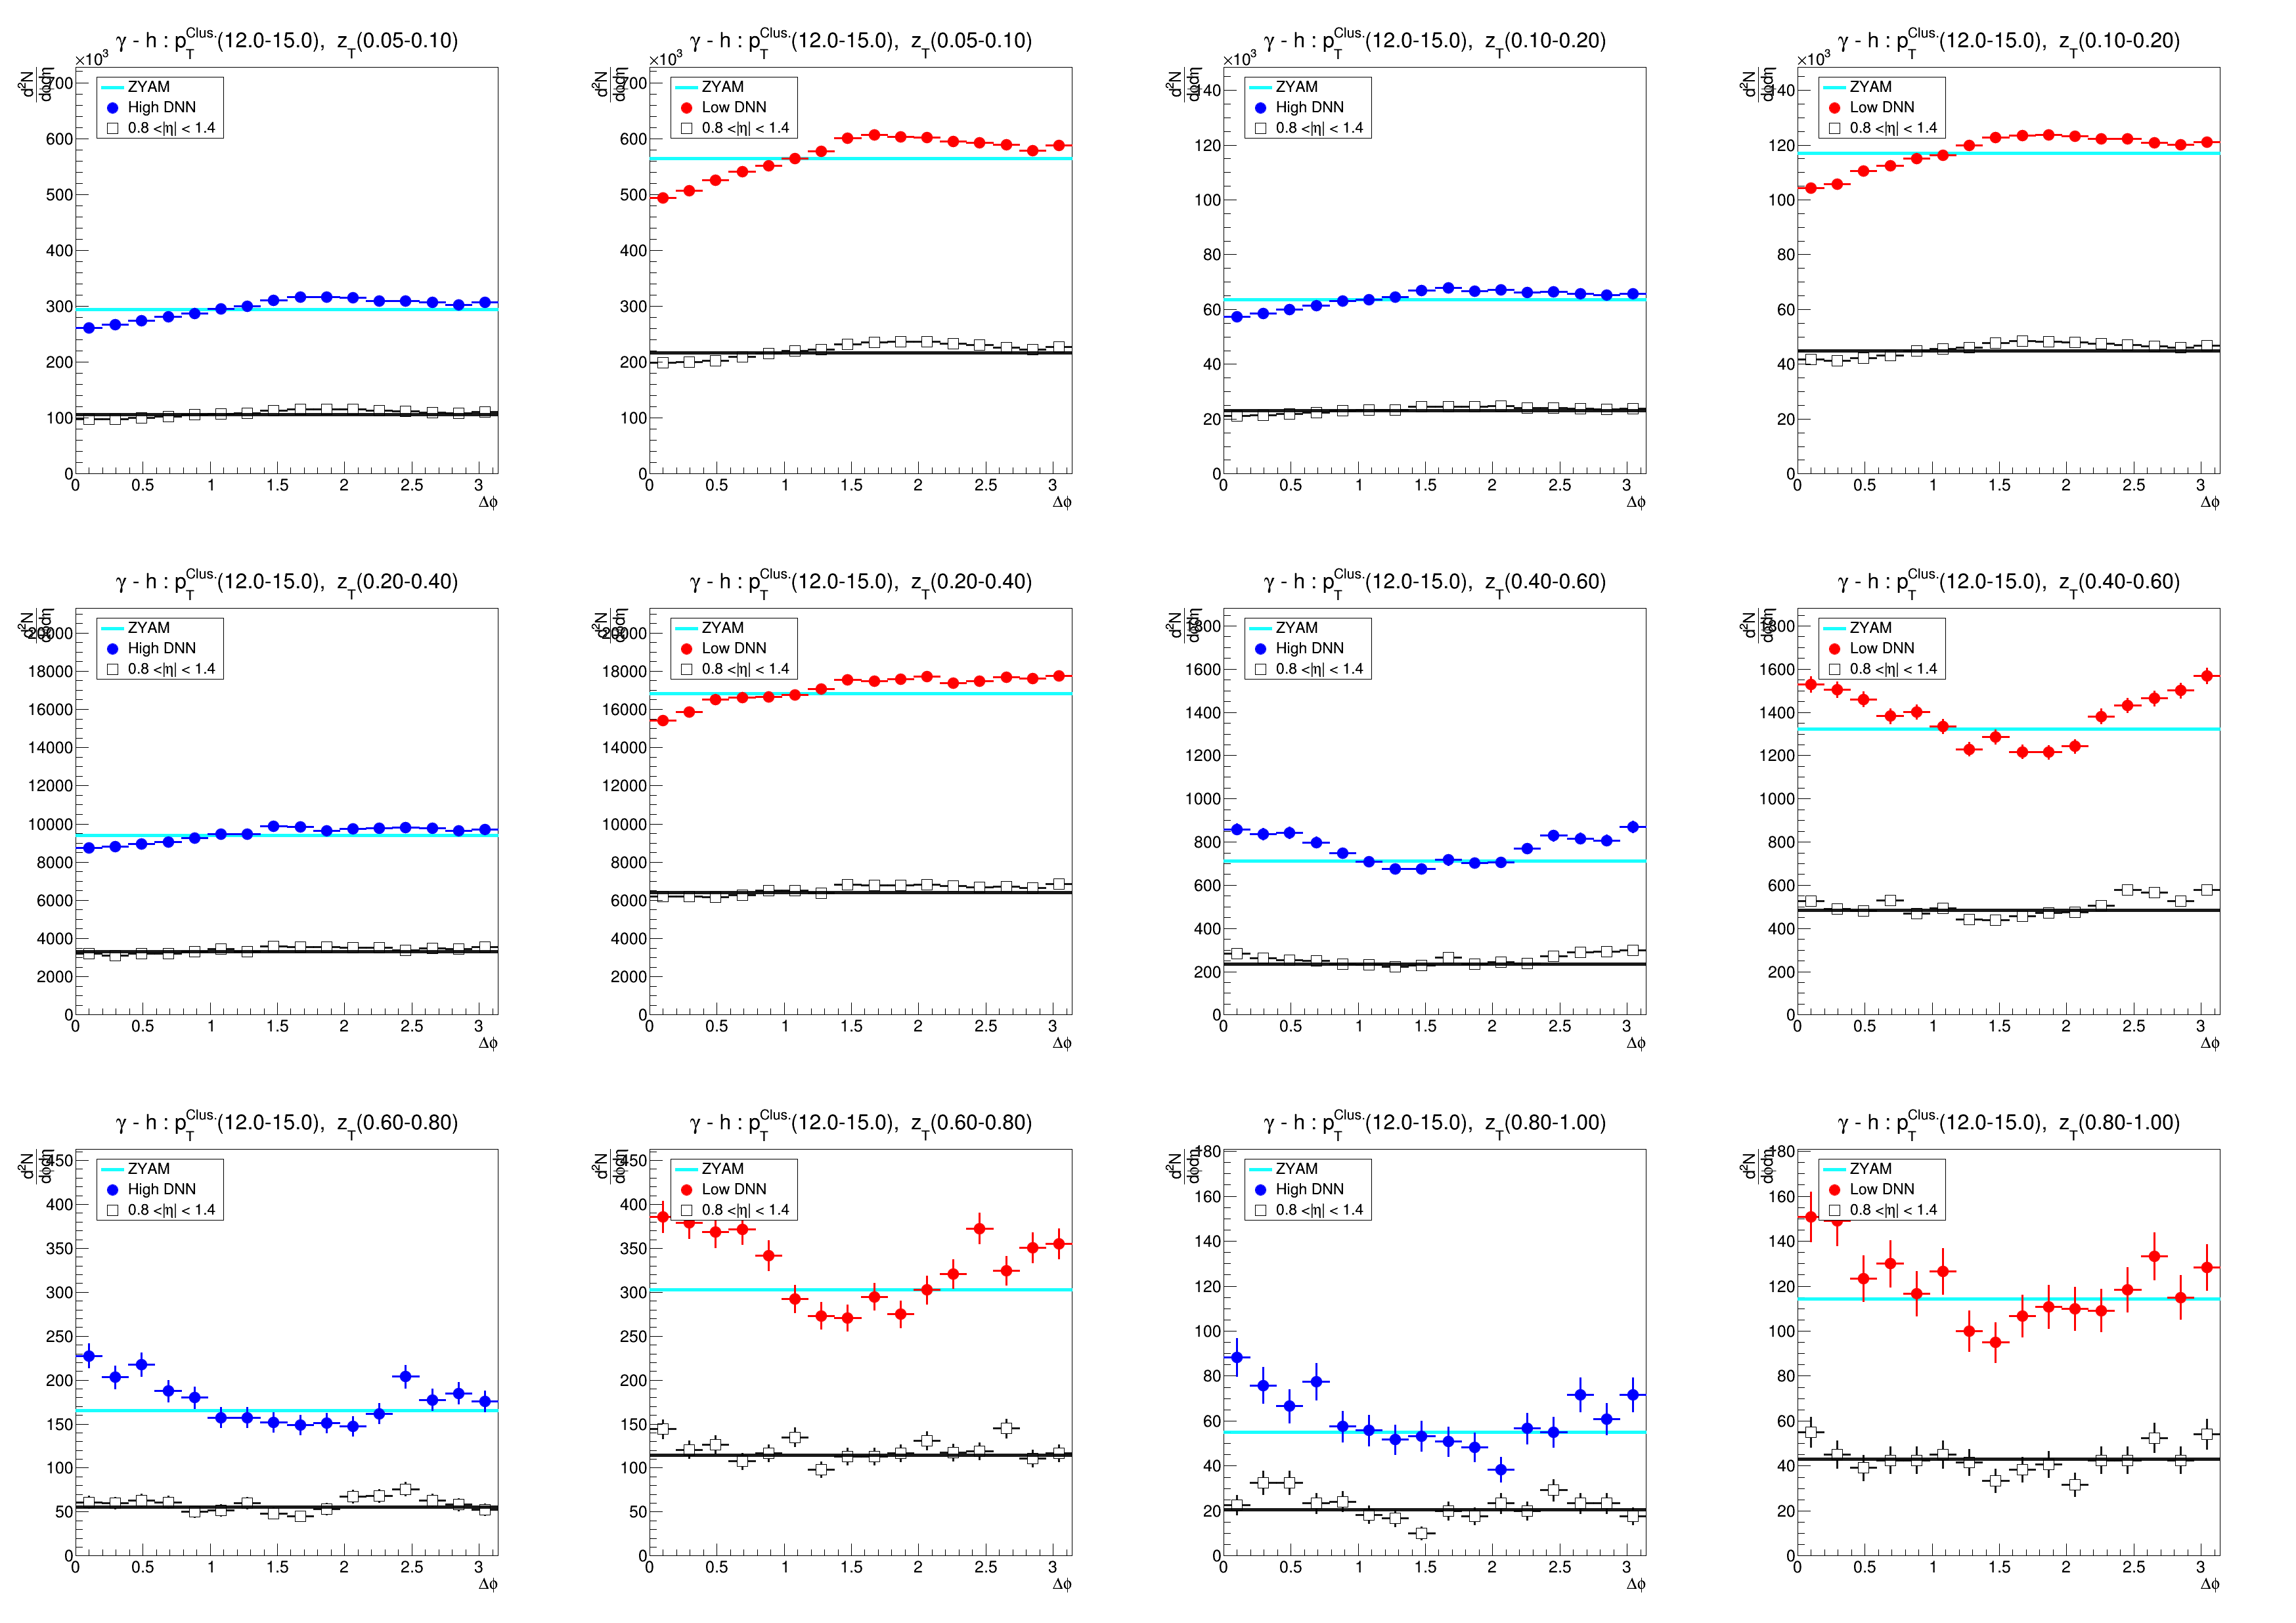

2


<ROOT.TCanvas object ("Canv_Side_Side_2") at 0x76eb330>

Info in <TCanvas::Print>: png file pics/Same_Mix_per_Trigger_pt_2.png has been created


In [49]:
SideSide()

# Purity Scaling + Subtraction

#### Subtraction: $C_{S} = \frac{C_{SR} - (1-p) C_{BR}}{p}$

In [29]:
def GetBKGsubtracted(filename, ptbin, ztbin, doZYAM=True, doSubtraction=True):
    Signal = GetPhiProj(filename,ptbin,ztbin,True,doZYAM) #High DNN (True)
    Background = GetPhiProj(filename,ptbin,ztbin,False,doZYAM) #Low DNN (False)
    N1 = Get_NTriggers(filename, ptbin, True)
    N2 = Get_NTriggers(filename, ptbin, False)
    Background.Scale((1-purity[ptbin]))
   
    if (doSubtraction):
        Signal.Add(Background,-1)
        #Root handles errors correctly. Have checked with manual quadrature sum
    
    #Division by NTriggers done at phi projection function
    Signal.Scale(1.0/purity[ptbin])
    Background.Scale(1.0/purity[ptbin])
    
    Signal.GetYaxis().SetTitle("#frac{1}{N_{Trig}}#frac{d^{2}N}{d#phid#eta}")
    Background.GetYaxis().SetTitle("#frac{1}{N_{Trig}}#frac{d^{2}N}{d#phid#eta}")
    return Signal,Background,N1

In [30]:
def DrawLabel(NTriggers,ptbin):
    latex = TLatex()
    latex.SetNDC()
    latex.SetTextSize(0.03)
    #latex.DrawLatex(0.38,0.97, "#color[2]{ Scaled by 1-purity[ptbin]}")
    latex.DrawLatex(0.12,0.85, "#color[2]{Scaled by purity = %1.2f}"%(purity[ptbin]))
    #latex.DrawLatex(0.12,0.85, "#color[2]{no purity scaling}")
    latex.DrawLatex(0.12,0.81, "#color[4]{%1.0f Triggers}"%(NTriggers))
    #latex.DrawLatex(0.45,0.90, "8 < p_{T}^{cluster} < 16 GeV")
    #latex.DrawLatex(0.45,0.85, "0.55 < DNN <0.85")
    #latex.DrawLatex(0.45,0.80,"0.2< z_{T}< 0.4")

# Loop and Plot

In [31]:
def Looping(filename,DoZYAM,DoSub=True):
    canvases = []
    for ptbin in range(3):
        canvases.append(ROOT.TCanvas("canv%i"%(ptbin),"canv",3000,2000))
        canvases[ptbin].Divide(3,2)
        if (ptbin > 0): continue;
        ptbin = ptbin+2
        for ztbin in range(6):
            hsig,hbkg,NTrig = GetBKGsubtracted(filename,ptbin,ztbin,DoZYAM,DoSub)#doZYAM,doSubtraction
            canvases[ptbin-2].cd(ztbin+1)            
            
            ymax = 1.2*max(hsig.GetMaximum(),hbkg.GetMaximum())
            ymin = -2*abs(min(hsig.GetMinimum(),hbkg.GetMinimum()))
            hsig.GetYaxis().SetRangeUser(ymin,ymax)
            hbkg.GetYaxis().SetRangeUser(ymin,ymax)            
            hsig.Draw()

            #Overlay
            if not(DoSub): 
                hbkg.Draw("same")
                canvases[ptbin-2].Update()
                legend = ROOT.TLegend(0.74,0.78,0.89,0.88)
                legend.AddEntry(hsig, "0.55 < DNN < 0.85","p")
                legend.AddEntry(hbkg, "0.0 < DNN < 0.3","p")
                SetOwnership(legend, 0) # 0 = release (not keep), 1 = keep
                legend.Draw("same")
                
                #show unscaled
                #Bkgd = GetPhiProj(filename,ptbin,ztbin,False,DoZYAM)
                #Bkgd.SetMarkerStyle(21)
                #Bkgd.Draw("same")
        
            else:     
                #draw line at 0
                zero_line = ROOT.TLine(0,0,math.pi,0)
                zero_line.SetLineColorAlpha(2, 0.9)
                zero_line.SetLineWidth(2)
                SetOwnership(zero_line, 0)
                zero_line.Draw("same")
            
            #TPave
            DrawLabel(NTrig,ptbin)
        canvases[ptbin-2].Draw()
  
        if (DoSub): canvases[ptbin-2].SaveAs('pics/correlations_Subtracted_ptbin%i.png'%(ptbin))
        else: canvases[ptbin-2].SaveAs('pics/correlations_Overlay_ptbin%i.png'%(ptbin))
    return canvases

In [ ]:
Looping(RootFile,True,True)#Filename,DoZYAM,DoSub

# Fragmentation Function

In [ ]:
def FF(filename):
    zT_integral = []
    zT_point = []
    zT_error = []
    for ptbin in range(3):
        if (ptbin > 0): continue;
        ptbin = ptbin+2
        
        for ztbin in range(6):
            hsig,hbkg,NTrig = GetBKGsubtracted(filename,ptbin,ztbin,True,True)#doZYAM,doSubtraction 
            Phi_bin_min = hsig.GetXaxis().FindBin(2*math.pi/3)
            Phi_bin_max = hsig.GetXaxis().FindBin(math.pi)-1    
            zT_point.append((zTbins[ztbin] + zTbins[ztbin+1])/2)
            zT_integral.append(hsig.Integral(hsig.GetXaxis().FindBin(2*math.pi/3),hsig.GetXaxis().FindBin(math.pi)))
            
            #errors
            zt_tmp_e = 0.0
            for phibin in range(Phi_bin_min, Phi_bin_max+1):
                print "Relative Error: ",hsig.GetBinError(phibin)/(hsig.GetBinContent(phibin))," Bin Content ", hsig.GetBinContent(phibin), " Absolute Error: ", hsig.GetBinError(phibin)
                
                zt_tmp_e += (hsig.GetBinError(phibin))**2
                #print math.sqrt(zt_tmp_e)
            print "Quadrature sum, relative Error", (math.sqrt(zt_tmp_e)/zT_integral[ztbin])
            print " "
            zT_error.append(math.sqrt(zt_tmp_e))
            
    #print zT_error
    plt.plot(zT_point,zT_integral,'bo')
    plt.errorbar(zT_point, zT_integral, yerr=zT_error, fmt='.')
    plt.yscale('linear')
    plt.xscale('log')
    locator = matplotlib.ticker.MaxNLocator(nbins=8) # with 3 bins you will have 4 ticks
    plt.title('Integrated $\gamma$-Hadron $2\pi/3 < \Delta\phi < \pi$ ')

In [ ]:
FF(RootFile)

In [ ]:
np.geomspace(0.05,1,8)